# 6. Stochastic and Mini-Batch GD

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (17/12/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Numpy
import numpy as np
# Removing unecessary warnings (optional, just makes notebook outputs more readable)
import warnings
warnings.filterwarnings("ignore")

### Mock dataset, with nonlinearity

As in the previous notebook.

In [30]:
# All helper functions
eps = 1e-5
min_val = -1 + eps
max_val = 1 - eps
def val(min_val, max_val):
    return round(np.random.uniform(min_val, max_val), 2)
def class_for_val(val1, val2):
    k = np.pi
    return int(val2 >= -1/4 + 3/4*np.sin(val1*k))
n_points = 1000
def create_dataset(n_points, min_val, max_val):
    val1_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    val2_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    inputs = np.array([[v1, v2] for v1, v2 in zip(val1_list, val2_list)])
    outputs = np.array([class_for_val(v1, v2) for v1, v2 in zip(val1_list, val2_list)]).reshape(n_points, 1)
    return val1_list, val2_list, inputs, outputs

In [31]:
# Generate dataset
np.random.seed(47)
val1_list, val2_list, inputs, outputs = create_dataset(n_points, min_val, max_val)
# Check a few entries of the dataset
print(val1_list.shape)
print(val2_list.shape)
print(inputs.shape)
print(outputs.shape)
print(inputs[0:10, :])
print(outputs[0:10])

(1000,)
(1000,)
(1000, 2)
(1000, 1)
[[-0.77 -0.6 ]
 [ 0.95  0.28]
 [ 0.46 -0.91]
 [-0.3   0.23]
 [ 0.42 -0.61]
 [ 0.6   0.97]
 [ 0.29  0.37]
 [-0.17  0.4 ]
 [ 0.41  0.29]
 [-0.51  0.02]]
[[1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]]


As expected and observed in the plots below, the dataset now longer exhibits linearity. In fact the function is no longer polynomial either due to the presence of a logarithmic function.

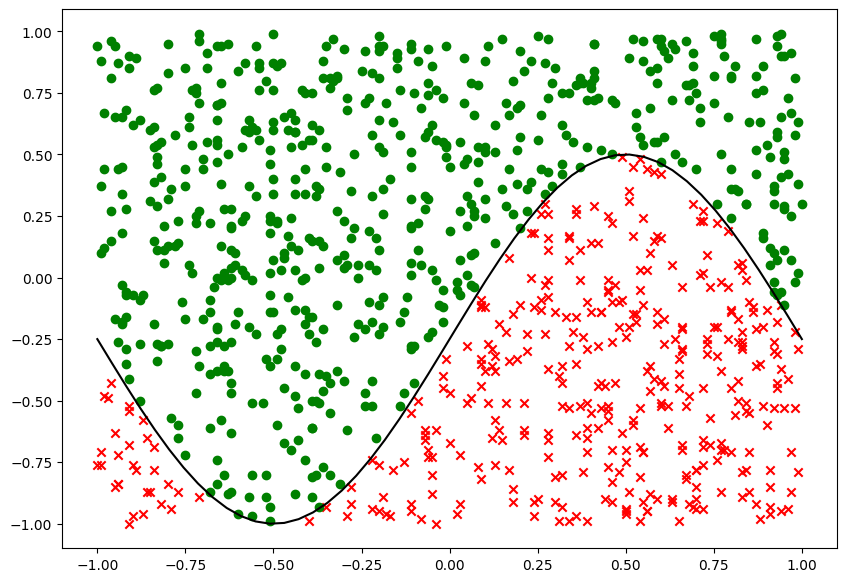

In [32]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])
    
# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary")

# Show
plt.show()

### Shallow Neural Net with Sigmoid Activations, with Batch Gradient Descent 

...

In [42]:
class ShallowNeuralNet_Batch():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        self.loss = -np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, G_list, iteration_number, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
    
        # Compute error term
        epsilon = y_pred - outputs
        gradient_output = epsilon*y_pred*(1 - y_pred)
        error_hidden = np.dot(gradient_output, self.W2.T)
        gradient_hidden = error_hidden*A1*(1 - A1)
        
        # Compute gradients
        grad_W2 = -(1/m)*np.dot(A1.T, gradient_output)
        grad_W1 = -(1/m)*np.dot(inputs.T, gradient_hidden)
        grad_b2 = -(1/m)*np.sum(gradient_output, axis = 0, keepdims = True)
        grad_b1 = -(1/m)*np.sum(gradient_hidden, axis = 0, keepdims = True)
        
        # Momentum and gradient decay/normalization for each parameter
        V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1 = G_list
        V_W2 = beta1*V_W2 + (1 - beta1)*grad_W2
        V_W1 = beta1*V_W1 + (1 - beta1)*grad_W1
        V_b2 = beta1*V_b2 + (1 - beta1)*grad_b2
        V_b1 = beta1*V_b1 + (1 - beta1)*grad_b1
        V_W2_norm = V_W2/(1 - beta1**iteration_number)
        V_W1_norm = V_W1/(1 - beta1**iteration_number)
        V_b2_norm = V_b2/(1 - beta1**iteration_number)
        V_b1_norm = V_b1/(1 - beta1**iteration_number)
        S_W2 = beta2*S_W2 + (1 - beta2)*grad_W2**2
        S_W1 = beta2*S_W1 + (1 - beta2)*grad_W1**2
        S_b2 = beta2*S_b2 + (1 - beta2)*grad_b2**2
        S_b1 = beta2*S_b1 + (1 - beta2)*grad_b1**2
        S_W2_norm = S_W2/(1 - beta2**iteration_number)
        S_W1_norm = S_W1/(1 - beta2**iteration_number)
        S_b2_norm = S_b2/(1 - beta2**iteration_number)
        S_b1_norm = S_b1/(1 - beta2**iteration_number)
        G_list = [V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1]
        
        # Gradient descent update rules
        eps = 1e-6
        self.W2 += alpha*V_W2_norm/(np.sqrt(S_W2_norm) + eps)
        self.W1 += alpha*V_W1_norm/(np.sqrt(S_W1_norm) + eps)
        self.b2 += alpha*V_b2_norm/(np.sqrt(S_b2_norm) + eps)
        self.b1 += alpha*V_b1_norm/(np.sqrt(S_b1_norm) + eps)
        
        # Update loss
        self.CE_loss(inputs, outputs)
        return G_list
    
    def train(self, N_max = 1000, alpha = 1e-5, beta1 = 0.1, beta2 = 0.1, beta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Initialize G_list
        G_list = [0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1, \
                  0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            G_list = self.backward(inputs, outputs, G_list, iteration_number, alpha, beta1, beta2)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max//100) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for beta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < beta):
                if(display):
                    print("Stopping early - loss evolution was less than beta.")
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

In [43]:
# Define neural network structure (random normal initialization)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_batch = ShallowNeuralNet_Batch(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net_batch.train(N_max = 100000, alpha = 1e-1, beta1 = 0.1, beta2 = 0.1, beta = 1e-10, display = True)
print(shallow_neural_net_batch.loss)

Iteration 1 - Loss = 0.6561840401736492
Iteration 1001 - Loss = 0.06957061740137217
Iteration 2001 - Loss = 0.03705179833130585
Iteration 3001 - Loss = 0.025789702410652093
Iteration 4001 - Loss = 0.01979992219578917
Iteration 5001 - Loss = 0.01570796235935389
Iteration 6001 - Loss = 0.012970469911671077
Iteration 7001 - Loss = 0.011041365609532222
Iteration 8001 - Loss = 0.009597736690953072
Iteration 9001 - Loss = 0.00847319759232889
Iteration 10001 - Loss = 0.0075743165130637245
Iteration 11001 - Loss = 0.0068439568014276855
Iteration 12001 - Loss = 0.006243001782854512
Iteration 13001 - Loss = 0.005743136273245126
Iteration 14001 - Loss = 0.005305974585229588
Iteration 15001 - Loss = 0.004931249289351254
Iteration 16001 - Loss = 0.004596770950563831
Iteration 17001 - Loss = 0.004277527919212828
Iteration 18001 - Loss = 0.003947047744738254
Iteration 19001 - Loss = 0.0036157373139055473
Iteration 20001 - Loss = 0.0033229570156049935
Iteration 21001 - Loss = 0.0030845845848466763
Ite

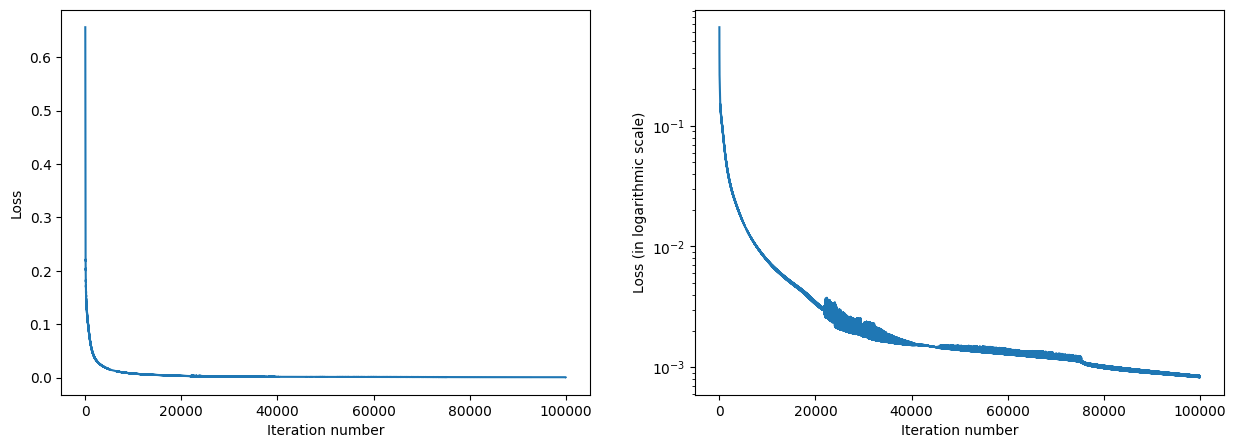

In [44]:
shallow_neural_net_batch.show_losses_over_training()

### Final visualizations and discussion

...

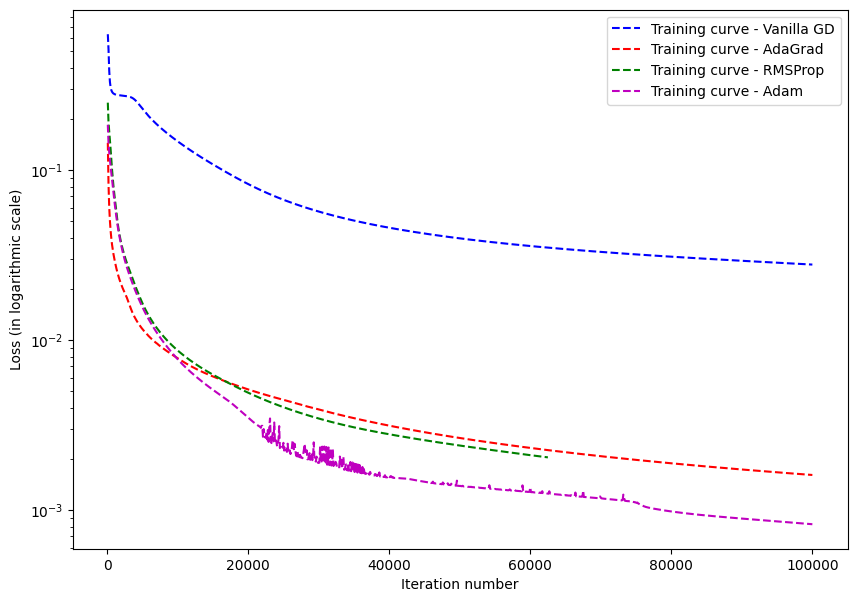

In [45]:
# Compare training curves
fig = plt.figure(figsize = (10, 7))
plt.plot(list(range(0, len(shallow_neural_net_batch.losses_list), 100)), \
         shallow_neural_net_batch.losses_list[::100], "b--", label = "Training curve - Batch GD")
plt.plot(list(range(0, len(shallow_neural_net_batch.losses_list), 100)), \
         shallow_neural_net_batch.losses_list[::100], "r--", label = "Training curve - Stochastic GD ")
plt.plot(list(range(0, len(shallow_neural_net_batch.losses_list), 100)), \
         shallow_neural_net_batch.losses_list[::100], "g--", label = "Training curve - Mini-batch GD")
plt.plot(list(range(0, len(shallow_neural_net_batch.losses_list), 100)), \
         shallow_neural_net_batch.losses_list[::100], "m--", label = "Training curve - Mini-batch Stochastic GD")
plt.xlabel("Iteration number")
plt.ylabel("Loss (in logarithmic scale)")
plt.yscale("log")
plt.legend(loc = "best")

In [46]:
def find_v2(v1, model, min_val, max_val, thr = 1e-3):
    # Dichotomic search, to be used for boundary drawing later
    v2_min = min_val
    v2_max = max_val
    while((v2_max - v2_min) > thr):
        v2_avg = (v2_max + v2_min)/2
        out = model.forward([v1, v2_avg])
        if(out > 0.5):
            v2_max = v2_avg
        else:
            v2_min = v2_avg
    return (v2_max + v2_min)/2

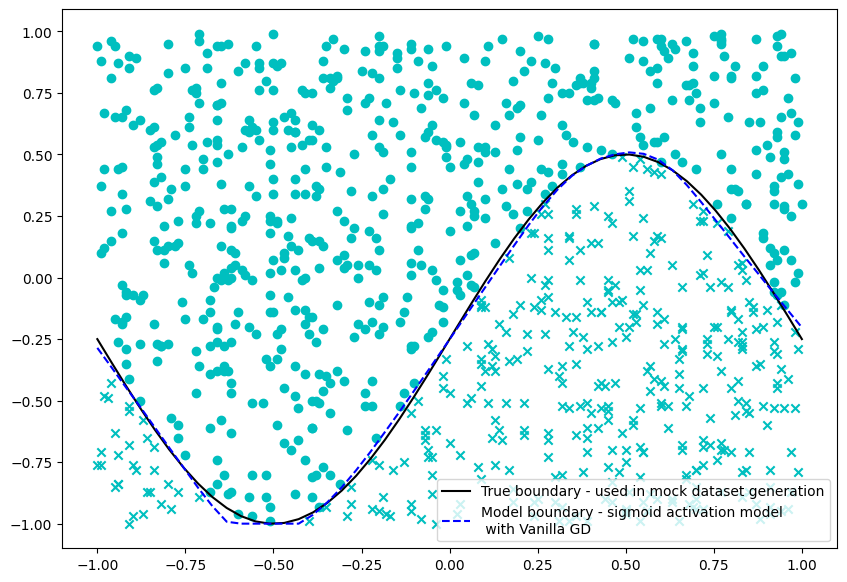

In [60]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - used in mock dataset generation")

# Display model boundary (sigmoid model, vanilla GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_vanilla = [find_v2(v1, shallow_neural_net_vanilla, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_vanilla, "b--", label = "Model boundary - sigmoid activation model \n with Vanilla GD")

# Show
plt.legend(loc = "best")
plt.show()

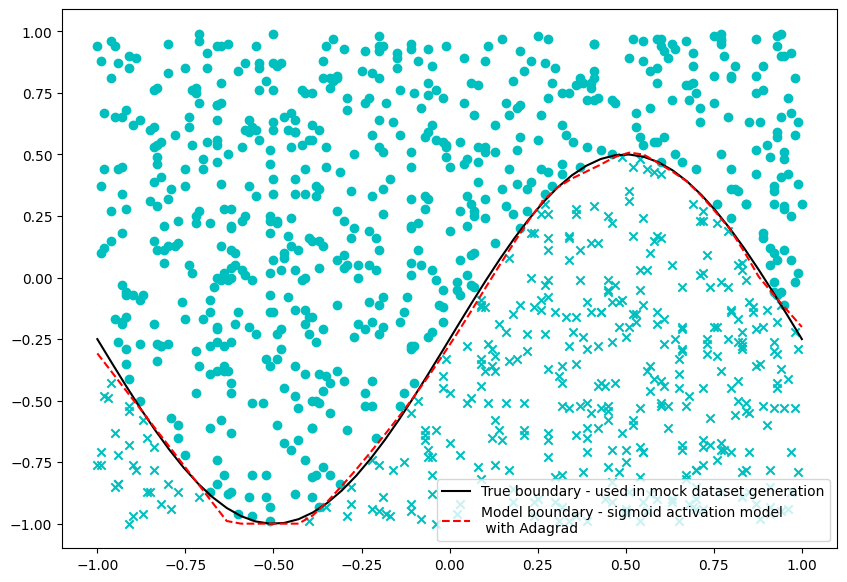

In [61]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - used in mock dataset generation")

# Display model boundary (sigmoid model, Adagrad GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_adagrad = [find_v2(v1, shallow_neural_net_adagrad, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_adagrad, "r--", label = "Model boundary - sigmoid activation model \n with Adagrad")

# Show
plt.legend(loc = "best")
plt.show()

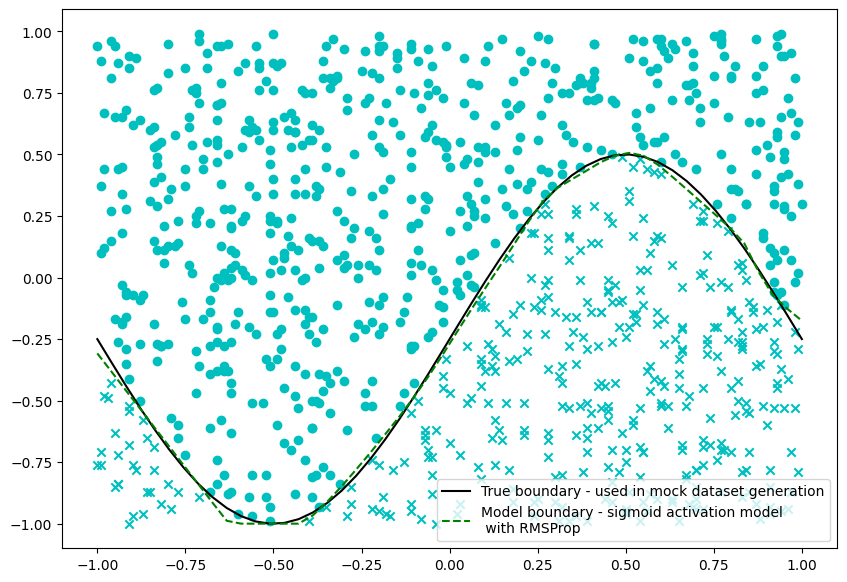

In [62]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - used in mock dataset generation")

# Display model boundary (sigmoid model, RMSProp GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_rmsprop = [find_v2(v1, shallow_neural_net_rmsprop, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_rmsprop, "g--", label = "Model boundary - sigmoid activation model \n with RMSProp")

# Show
plt.legend(loc = "best")
plt.show()

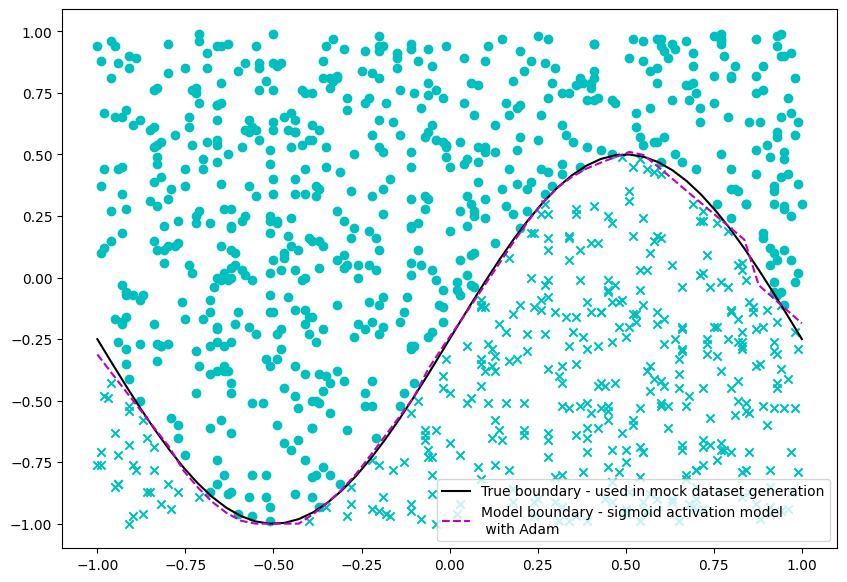

In [63]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - used in mock dataset generation")

# Display model boundary (sigmoid model, Adam GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_adam = [find_v2(v1, shallow_neural_net_adam, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_adam, "m--", label = "Model boundary - sigmoid activation model \n with Adam")

# Show
plt.legend(loc = "best")
plt.show()

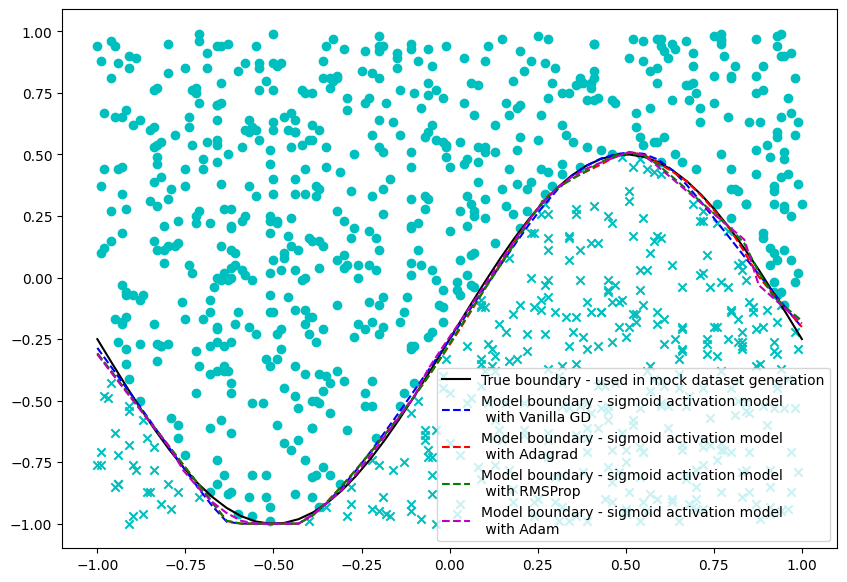

In [64]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - used in mock dataset generation")

# Display model boundary (sigmoid model, vanilla GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_vanilla = [find_v2(v1, shallow_neural_net_vanilla, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_vanilla, "b--", label = "Model boundary - sigmoid activation model \n with Vanilla GD")

# Display model boundary (sigmoid model, Adagrad GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_adagrad = [find_v2(v1, shallow_neural_net_adagrad, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_adagrad, "r--", label = "Model boundary - sigmoid activation model \n with Adagrad")

# Display model boundary (sigmoid model, RMSProp GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_rmsprop = [find_v2(v1, shallow_neural_net_rmsprop, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_rmsprop, "g--", label = "Model boundary - sigmoid activation model \n with RMSProp")

# Display model boundary (sigmoid model, Adam GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_adam = [find_v2(v1, shallow_neural_net_adam, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_adam, "m--", label = "Model boundary - sigmoid activation model \n with Adam")

# Show
plt.legend(loc = "best")
plt.show()

### What's next?

In the next notebook, we will investigate some additional variations on these optimizers, along with the mini-batch optimization procedure.

In [10]:
inputs = np.array([[i, i**2] for i in range(10)])
print(inputs)
outputs = np.array([[i**3] for i in range(10)])
print(outputs)
shuffler = np.random.permutation(len(inputs))
print(shuffler)
inputs_shuffled = inputs[shuffler, :]
outputs_shuffled = outputs[shuffler, :]
print(inputs_shuffled)
print(outputs_shuffled)

[[ 0  0]
 [ 1  1]
 [ 2  4]
 [ 3  9]
 [ 4 16]
 [ 5 25]
 [ 6 36]
 [ 7 49]
 [ 8 64]
 [ 9 81]]
[[  0]
 [  1]
 [  8]
 [ 27]
 [ 64]
 [125]
 [216]
 [343]
 [512]
 [729]]
[2 6 0 8 4 9 5 3 7 1]
[[ 2  4]
 [ 6 36]
 [ 0  0]
 [ 8 64]
 [ 4 16]
 [ 9 81]
 [ 5 25]
 [ 3  9]
 [ 7 49]
 [ 1  1]]
[[  8]
 [216]
 [  0]
 [512]
 [ 64]
 [729]
 [125]
 [ 27]
 [343]
 [  1]]
